# Nearest Neighbors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from numpy import linalg as nplin
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd

**Generating Toy Data**: in this case, we will use a slightly more challenging toy dataset that cannot be classified perfectly using a linear classifier (i.e. there is no way to draw a single line separating the red points from the green points). The toy dataset will be in d = 2 dimensions i.e. 2D with n = 40 points per class but the points of each class would be scattered across two clusters. From our previous experience with LwP, we know that such diversity within a class can defeat the LwP algorithm. Can the kNN algorithm do better?

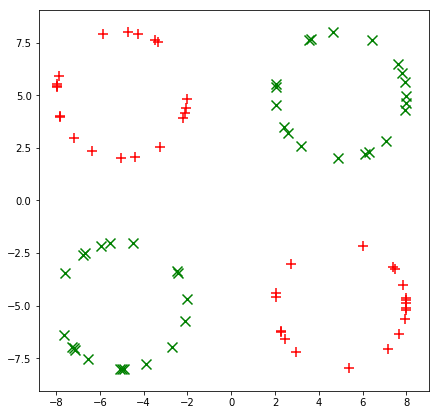

In [3]:
d = 2 
n = 20
r = 3

tmp1 = gsd.genSphericalData( d, n, [-5, 5], r )
tmp2 = gsd.genSphericalData( d, n, [5, -5], r )
XPos = np.vstack( (tmp1, tmp2) )
yPos = np.ones( (2*n,) )

tmp1 = gsd.genSphericalData( d, n, [5, 5], r )
tmp2 = gsd.genSphericalData( d, n, [-5, -5], r )
XNeg = np.vstack( (tmp1, tmp2) )
yNeg = -np.ones( (2*n,) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

fig1 = pd.getFigure()
pd.plot2D( XPos, fig1, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig1, color = 'g', marker = 'x' )

**Implementing the kNN Classifier**: we will now implement the kNN classifier to try and classify this data.
1. The model for the kNN classifier is the entire training data itself so nothing to do here.
1. Next, define a method called kNNClass that will take in a single 2D data point and tells us which label is most popular among the k-nearest points.
1. Use the plotting module to shade the entire 2D space and visualize the _decision boundary_

As we will notice, kNN is able to get perfect classification on the training data i.e. all red points are within the red shaded region and all green points are within the green shaded region. Thus, the _training error_ of the kNN classifier in this case is zero. However, kNN can behave weirdly with very large values of k. The value of k should be tuned carefully using validation (held out/cross).

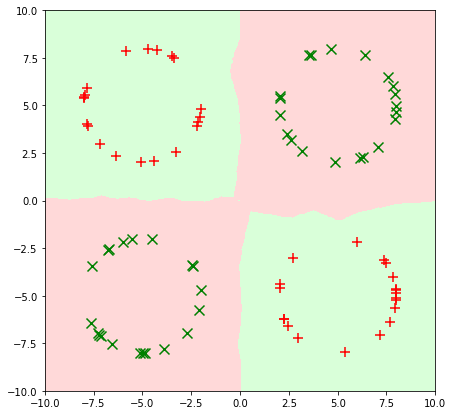

In [4]:
def kNNClass( xt, yt ):
    diff = X - np.array( [xt, yt] )
    dist = nplin.norm( diff, 2, axis = 1 )
    idx = np.argsort( dist )
    yhat = 0
    wsum = 0
    for i in range( k ):
        yhat = yhat + y[idx[i]]
    return yhat/k

# Vary the value of k -- take it to small values and then large values and see what happens to the decision boundaries
k = 2

fig2 = pd.getFigure()
pd.shade2D( kNNClass, fig2, mode = 'point', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig2, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig2, color = 'g', marker = 'x' )

**Regression using kNN**: we can even perform regression using the kNN algorithm by simply averaging the labels of the k-nearest neighbors instead of taking the majority label. Let us try to learn a simple sinusoid function using kNN. It should be noted that the kNN algorithm thrives on data i.e. it does much better with larger number of training points. Indeed kNN is a _universally consistent_ learning algorithm. This is true of classification as well as regression tasks.

In this specific example, kNN offers us a piecewise constant curve as its approximation to the true curve. The number of "pieces" increases with the number of training points. It can be seen that with a large training size, such as n = 200, the number of pieces is so large that the kNN approximation starts looking like a continuous function itself.

You may notice that choosing very large values of $k$ results in the algorithm giving a "flat" prediction, no matter whether the problem is a classification problem or a regression problem. Is this a coincidence or do you think you can argue why this must always happen?

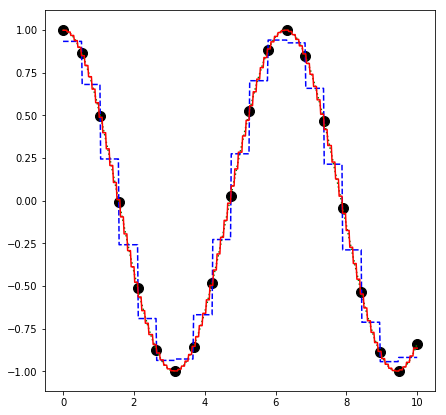

In [5]:
def kNNReg( x ):
    diff = X - x
    dist = [abs(d) for d in diff]
    idx = np.argsort( dist )
    yhat = 0
    for i in range( k ):
        yhat = yhat + y[idx[i]]
    return yhat/k

k = 2

n = 20
X = np.linspace( 0, 10, n, endpoint = True )
y = np.cos( X )

fig = pd.getFigure()
# Show where the training points lie
pd.plot2D( np.hstack( (X[:, np.newaxis], y[:, np.newaxis]) ), fig, color = 'k', marker = 'o', size = 100 )
# Plot the true curve
pd.plotCurve( np.cos, fig, color = 'g', linestyle = ":" )
# Plot what kNN predicts with 20 training points
pd.plotCurve( kNNReg, fig, color = 'b', linestyle = "--" )


# Let us try running kNN again but with more training points
n = 100
X = np.linspace( 0, 10, n, endpoint = True )
y = np.cos( X )

pd.plotCurve( kNNReg, fig, color = 'r', linestyle = "-" )

**Weighted kNN**: the kNN algorithm can be made more powerful by giving smaller weight to "neighbors" that relatively far off and more weight to those that are closer. Notice that in this specific example, weighted kNN gives us a smooth fit with just 20 data points whereas it took kNN 200 data points to give a similarly smooth fit!

The exact function we use to assign weights is a matter of choice but in general if a neighbor is a distance $d$ away from a test point then we would want to assign a weight $f(d)$ to the label of that neighbor Thus, weighted kNN can be seen as conducting a poll or a vote amongst the neighbors and the opinion of closer neighbors is given more weight i.e. matters more and those of farther neighbors matters less and is given less weight. Common examples include inverse i.e. $f(d) = \frac1d$ or more generally polynomial i.e. $f(d) = d^p$ for some $p < 0$, or even exponential $f(d) = \exp(-\alpha\cdot d)$ where $\alpha$ is a hyperparameter which decides how quickly do we want the weight to go down as $d$ goes up.

You may notice that choosing very small values of $\alpha$ will cause weighted kNN to behave similar to unweighted kNN. On the other hand, you may notice that choosing very large values of $\alpha$ will cause weighted kNN to behave like 1-NN (unweighted since weights dont matter in 1NN) no matter what value of $k$ you use (i.e. even weighted 5-NN will tend to behave like 1-NN if $\alpha$ is very large). Are these coincidences or must these always happen? If you think this will always happen, can you establish these two limiting behaviors of weighted kNN using a mathematical proof?

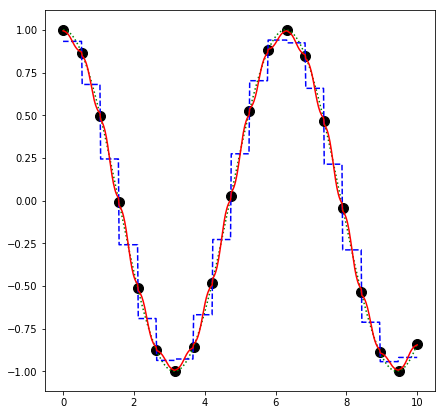

In [6]:
def wkNNReg( x ):
    diff = X - x
    dist = [abs(d) for d in diff]
    idx = np.argsort( dist )
    yhat = 0
    wsum = 0
    # We are choosing an exponential weight function with decay hyperparameter alpha = 6
    alpha = 6
    for i in range( k ):
        # Try other values of alpha (say alpha = 0.6 or 60) and see what happens
        yhat = yhat + y[idx[i]] * np.exp( -alpha * dist[idx[i]] )
        wsum = wsum + np.exp( -alpha * dist[idx[i]] )
    return yhat/wsum

n = 20
# Try other values of k (say k = 1 or k = 5) and see what happens
k = 2
X = np.linspace( 0, 10, n, endpoint = True )
y = np.cos( X )

fig2 = pd.getFigure()
pd.plot2D( np.hstack( (X[:, np.newaxis], y[:, np.newaxis]) ), fig2, color = 'k', marker = 'o', size = 100 )
pd.plotCurve( np.cos, fig2, color = 'g', linestyle = ":" )
# Plot what kNN predicts with these 20 training points
pd.plotCurve( kNNReg, fig2, color = 'b', linestyle = "--" )
# Weighted kNN is able to do far better with just 20 data points (comparable to kNN with 200 data points)
pd.plotCurve( wkNNReg, fig2, color = 'r', linestyle = "-" )